<a href="https://colab.research.google.com/github/nagusubra/nagusubra/blob/main/W%26B_and_UCalgary_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{bloodmnist-ucalgary-2023} -->

Use Weights & Biases for machine learning experiment tracking, dataset versioning, and project collaboration.


<img src="https://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />


## What this notebook covers with Weights and Biases:
* Using W&B to save and download your data
* Exploratory Data Analysis (EDA)
* Metrics logging 

# ✅ Sign Up

Sign up to a free [Weights & Biases account here](https://wandb.ai/signup)

[Weights and Biases Documentation / Quick Start](https://docs.wandb.ai/quickstart)

# Kaggle Competition Page

[Submit to the Competition here](https://www.kaggle.com/competitions/ucalgary-and-weights-biases-blood-mnist/)

# 🚀 Installing and importing

In [ ]:
!pip install -q --upgrade wandb
!pip install -qq timm

In [ ]:
import pandas as pd
import numpy as np

import math
import timm
import wandb
import random
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

Set some constants 

In [ ]:
PROJECT = 'blood-mnist-ucalgary-2023'
DATA_DIR = 'data'
ARTIFACT_PATH = 'wandb_fc/blood_mnist/blood_mnist_data:latest'

# 💾 Data
#### Download the data from W&B Artifacts
Train, validation and test images will be downloaded, as well as train and validation labels


In [ ]:
wandb.init(project=PROJECT, job_type='download_dataset')

artifact = wandb.use_artifact(ARTIFACT_PATH, type='competition_dataset')

artifact_dir = artifact.download(DATA_DIR)

wandb.finish()

## Prepare the Datasets and Dataloaders

The **BloodMNIST** dataset is part of the wider MedMNIST dataset. You can learn more about the MNIST project here: https://github.com/MedMNIST/MedMNIST

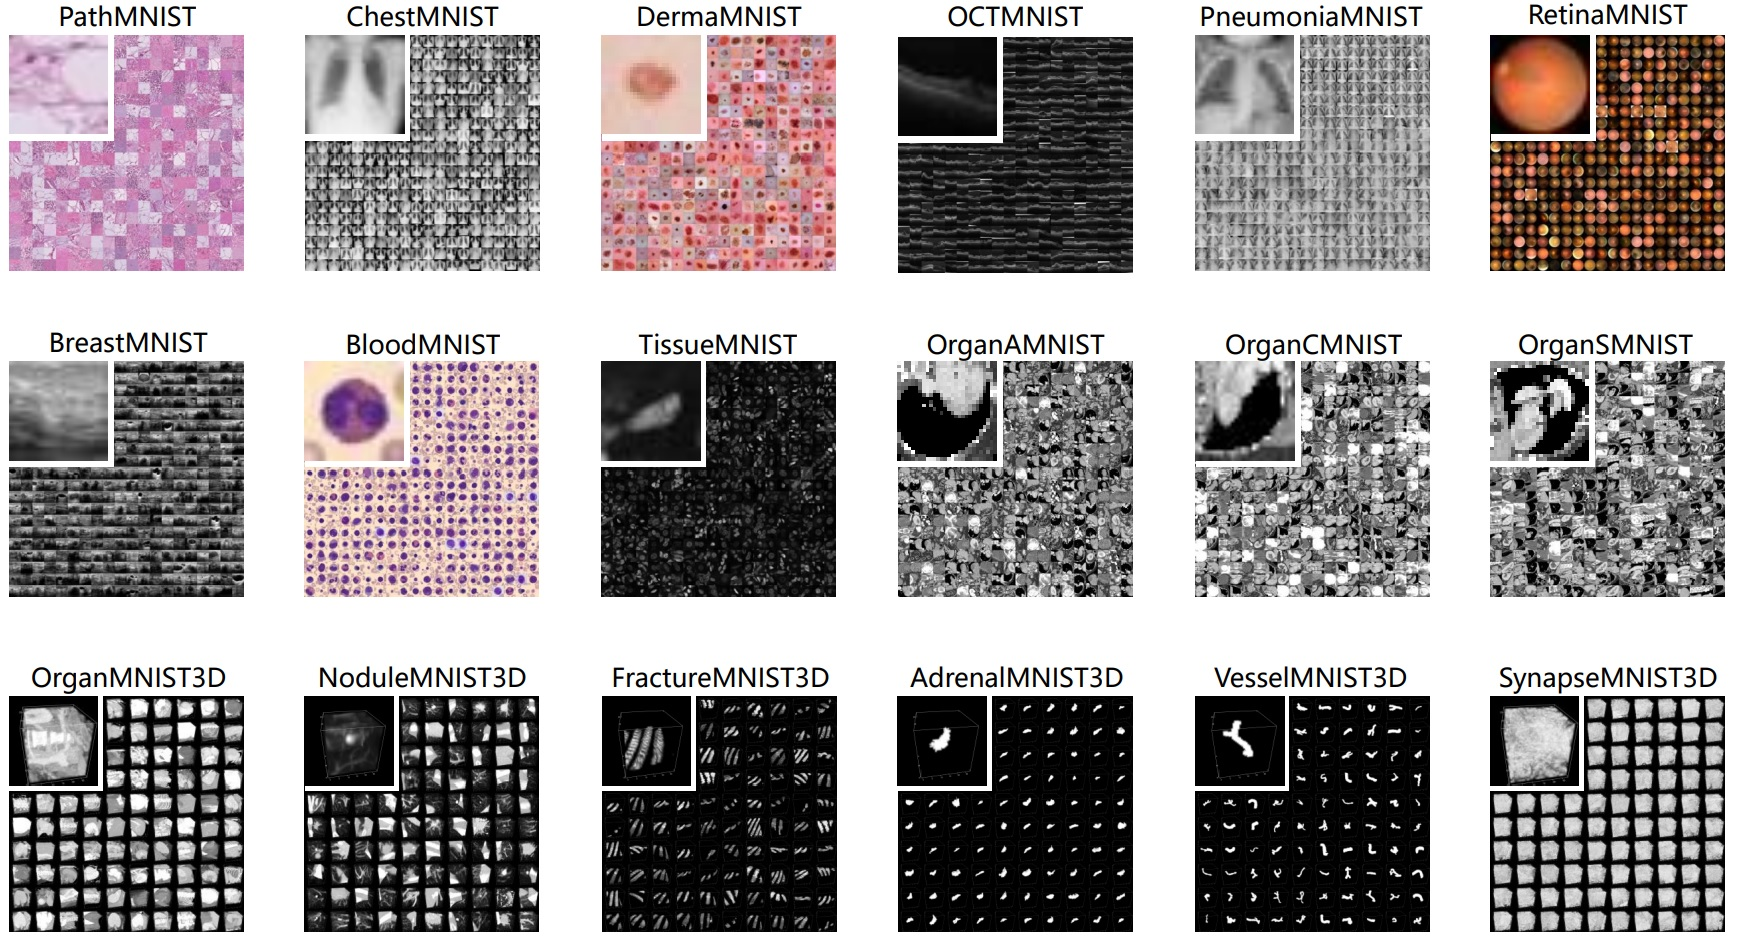

In [ ]:
class BloodMNISTImageDataset(Dataset):
    def __init__(self, image_path, labels_path=None, transforms=None):
        self.data = torch.load(image_path)
        if labels_path is not None:
          self.labels = torch.load(labels_path)
        else:
          self.labels = None
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].permute(2,0,1)
        img = self.transforms(img)
        if self.labels is not None:
          return img, self.labels[idx].long()
        else:
          return img

In [ ]:
def get_dataloader(dataset, is_train, batch_size):
    "Get a dataloader"
    loader = DataLoader(dataset=dataset, batch_size=batch_size, 
                        shuffle=True if is_train else False, 
                        pin_memory=True, num_workers=2)
    return loader


def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in tqdm(enumerate(valid_dl), leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log validation predictions and images to the dashboard
            if log_images:
              if i ==0:
                # 🐝 Create a wandb Table to log images, labels and predictions to
                table = wandb.Table(columns=["image", "label", "pred"]+[f"score_{i}" for i in range(8)])
              
              probs = outputs.softmax(dim=1)
              for img, label, pred, prob in zip(images.to("cpu"), labels.to("cpu"), predicted.to("cpu"),  probs.to("cpu")):
                  # table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
                  table.add_data(wandb.Image(img[0].numpy()), label, pred, *prob.numpy())
        
        if log_images:
          wandb.log({"val_table/predictions_table":table}, commit=False)

    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)

Initialise the Datasets and Dataloaders

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_tfms = T.Compose([
  # T.CenterCrop(10),
  T.ConvertImageDtype(torch.float),
 ])

val_tfms = T.Compose([
  T.ConvertImageDtype(torch.float),
 ])

train_dataset = BloodMNISTImageDataset(f'{DATA_DIR}/train_data.pt', f'{DATA_DIR}/train_labels.pt', transforms=train_tfms)
valid_dataset = BloodMNISTImageDataset(f'{DATA_DIR}/val_data.pt', f'{DATA_DIR}/val_labels.pt', transforms=val_tfms)
test_dataset = BloodMNISTImageDataset(f'{DATA_DIR}/test_data.pt', transforms=val_tfms)

In [ ]:
train_dataset[0][0].size(), valid_dataset[0][0].size(), test_dataset[0].size()

Initialise the dataloaders

In [ ]:
BS = 256

train_dl = get_dataloader(train_dataset, is_train=True, batch_size=BS)
valid_dl = get_dataloader(valid_dataset, is_train=False, batch_size=BS)
test_dl = get_dataloader(test_dataset, is_train=False, batch_size=BS)

In [ ]:
len(train_dl), len(valid_dl) , len(test_dl)

# 🖼️ EDA with W&B Tables
Log the train and validation datasets to W&B Tables for EDA

In [ ]:
# Create a W&B run
wandb.init(project=PROJECT, job_type='log_dataset')

# 🐝 Create a wandb Table to log images, labels and predictions to
table = wandb.Table(columns=["image", "label"])

for step, (images, labels) in enumerate(tqdm(train_dl, leave=False)):
  for img, label in zip(images.to("cpu"), labels.to("cpu")):
    w_img = wandb.Image(img[0].numpy())
    table.add_data(w_img, label)
  
  if step == 10: 
    break

wandb.log({'train_data/train_table':table})
wandb.finish()

Click on the `View run` link above to see your data logged to a Table.

After-event tip: when you have time check out the [Tables Quickstart](https://docs.wandb.ai/guides/data-vis/tables-quickstart) guide to learn all about the Tables functionality in the `wandb` library.

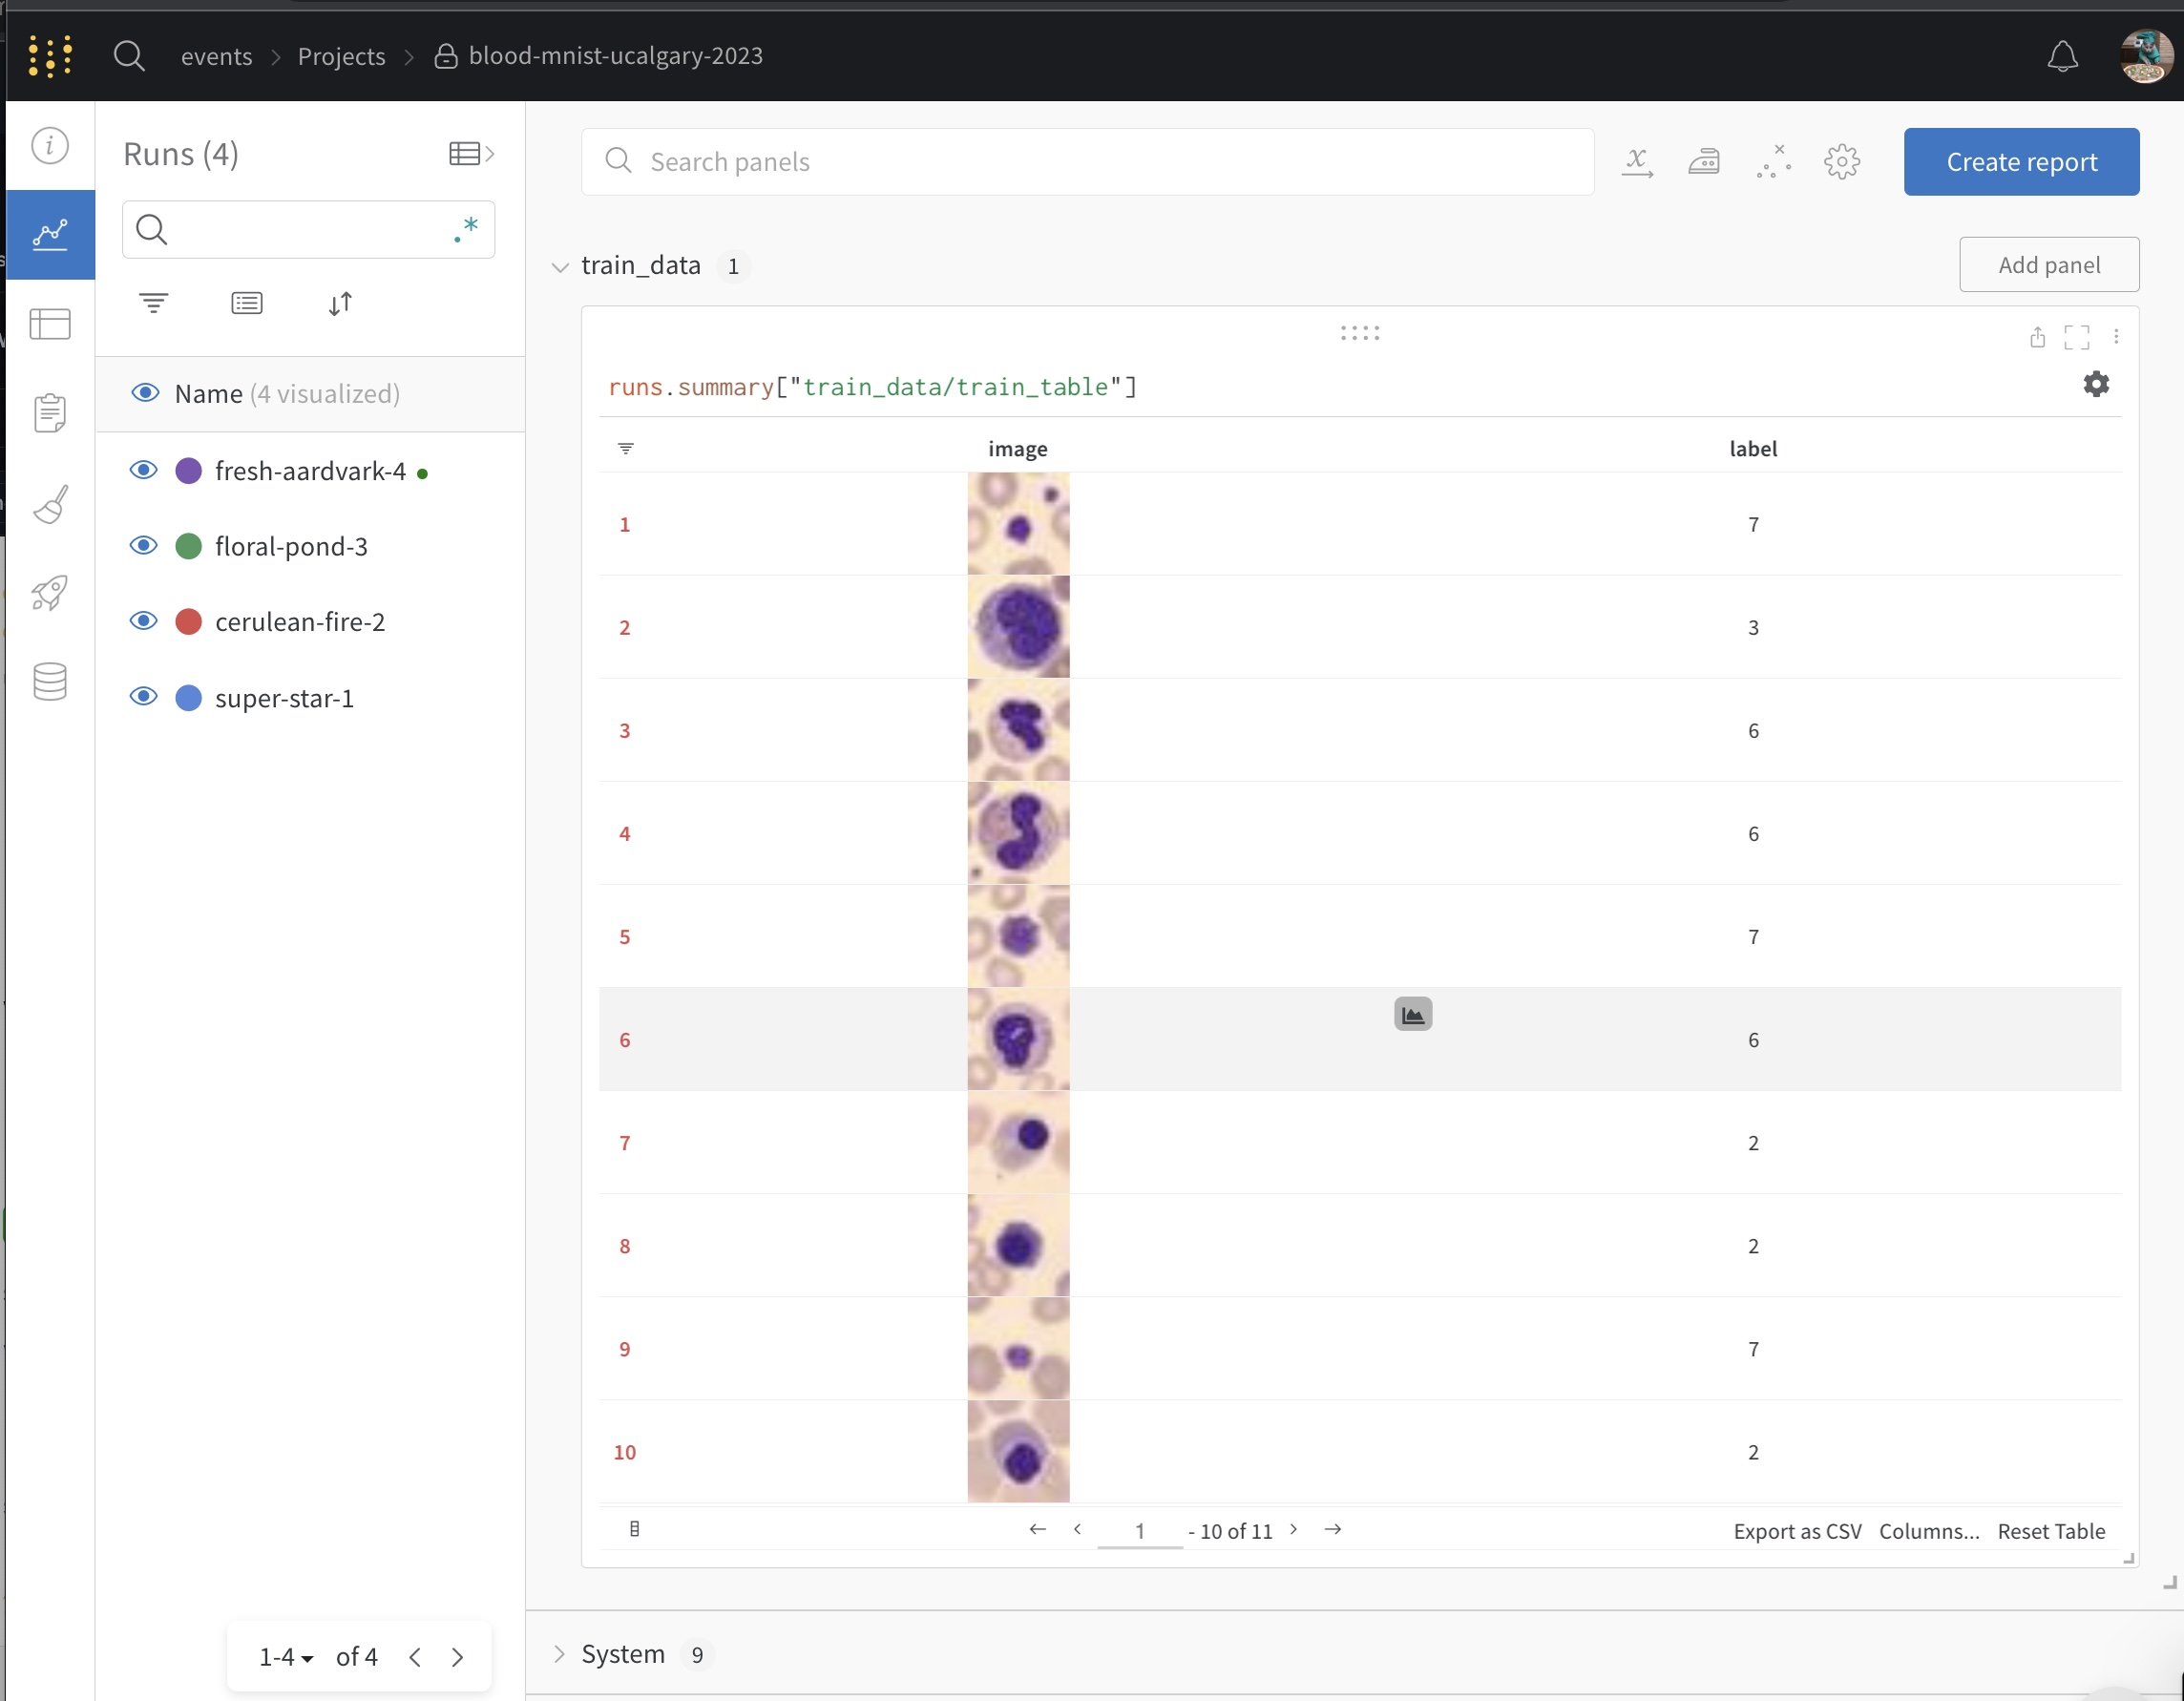

#👟 Train

In [ ]:
LR = 1e-6
EPOCHS = 80

# Log the final results on the validation set
LOG_IMAGES=True

**To try after the competition** When you have time please check our our **Hyperparameter Sweeps** section which will teach you how to use `wandb` to automatically iterate over dozens or hundreds of hyperparameters: https://docs.wandb.ai/guides/sweeps

No longer will you have to manually specify a learning rate of 0.005 train your model, and then specify a learning rate of 0.01, and so on. 

With Hyperparameter Sweeps `wandb` will handle 'sweeping' through the entire hyperparameter search space in an efficient way, freeing up your time to focus on the ML work that really matters!



Get Model

In [ ]:
MODEL_NAME = 'mobilenetv3_large_100'

model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=8)
model = model.to(device)

🐝 initialise a `wandb` run

To learn more about Runs in the `wandb` library please see this [Runs documentation page](https://docs.wandb.ai/ref/app/features/runs-table).

In [ ]:
wandb.init(project=PROJECT, config={"epochs": EPOCHS, "batch_size": BS, "lr": LR})

# Add additional configs to wandb if needed
wandb.config['len_train'] = len(train_dataset)
wandb.config['len_val'] = len(valid_dataset)

Start Training

In [ ]:
# Copy your config 
config = wandb.config

# Get the data
n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

# Make the loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

# Training
example_ct = 0
step_ct = 0
for epoch in tqdm(range(config.epochs)):
    model.train()
    for step, (images, labels) in enumerate(tqdm(train_dl, leave=False)):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        train_loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        example_ct += len(images)
        metrics = {"train/train_loss": train_loss, 
                    "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                    "train/example_ct": example_ct}
        
        if step + 1 < n_steps_per_epoch:
            # 🐝 Log train metrics to wandb 
            wandb.log(metrics)
            
        step_ct += 1
    
    # log validation images and predictions on last epoch
    if LOG_IMAGES:
      log_images = epoch==(config.epochs-1)
    else:
      log_images = False

    # Do validation and maybe log images to Tables
    val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=log_images)

    # 🐝 Log train and validation metrics to wandb
    val_metrics = {"val/val_loss": val_loss, 
                    "val/val_accuracy": accuracy}
    wandb.log({**metrics, **val_metrics})
    
    print(f"Epoch: {epoch}, Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Valid Accuracy: {accuracy:.2f}")

# Save trained model to disk and to W&B Artifacts
model_fn = f'{MODEL_NAME}_model.pt'
torch.save(model, model_fn)
wandb.log_artifact(model_fn, f'{MODEL_NAME}_model', type='model')

# Generate Test Submission
Generate Test Predictions and Log Submission File

In [ ]:
preds = []
for step, images in enumerate(tqdm(test_dl, leave=False)):
  images = images.to(device)
  outputs = model(images)
  preds.append(outputs.argmax(1).cpu().numpy().tolist())

preds = [p for ps in preds for p in ps]
len(preds)

In [ ]:
submission_df = pd.DataFrame({'Id':list(range(len(preds))), 'Category':preds})
submission_df.to_csv('submission.csv', index=False)

Log your submission file to your wandb run

In [ ]:
wandb.log_artifact('submission.csv', 'submission_file', type='submission')

🐝 Close your wandb run

In [ ]:
wandb.finish()

# 🪄 More from W&B

#### 📏 Best Practices

1. **Projects**: Log multiple runs to a project to compare them. `wandb.init(project="project-name")`
2. **Groups**: For multiple processes or cross validation folds, log each process as a run and group them together. `wandb.init(group='experiment-1')`
3. **Tags**: Add tags to track your current baseline or production model.
4. **Notes**: Type notes in the table to track the changes between runs.
5. **Reports**: Take quick notes on progress to share with colleagues and make dashboards and snapshots of your ML projects.

# What's next 🚀 ?
The next tutorial you will learn how to do hyperparameter optimization using W&B Sweeps:
## 👉 [Hyperparameters sweeps using PyTorch](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb)